# Observed Death Rates and Age-Sex Adjusted Expected Death Rates from COVID-19
### By Sayorn Chin
#### 09/14/2021

In [3]:
# Import libraries
import requests
import pandas as pd
import os
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [4]:
# Set working directory
cwd = os.getcwd()
path = cwd + "/age_sex_adjusted_expected_death_rate_residuals.csv"

In [5]:
# Create function for easier data cleaning
def text_matching(ser, match_name, default=None, regex=False, case=False):
    """ 
    Search a series for text matches.
    
    ser: pandas series to search
    match_name: tuple containing text to search for and text to use for normalization
    default: If no match, use this to provide a default value, otherwise use the original text
    regex: Boolean to indicate if match_name contains a regular expression
    case: Case sensitive search

    Returns a pandas series with the matched value

    """
    seen = None
    for match, name in match_name:
        mask = ser.str.contains(match, case=case, regex=regex)
        if seen is None:
            seen = mask
        else:
            seen |= mask
        ser = ser.where(~mask, name)
    if default:
        ser = ser.where(seen, default)
    else:
        ser = ser.where(seen, ser.values)
    return ser

In [6]:
# API info
host = "https://api.census.gov/data"

dataset = "timeseries/idb/1year"

base_url = "/".join([host, dataset])

predicates = {}

get_vars = ["NAME", "AGE", "POP"]

predicates["get"] = ",".join(get_vars)

predicates['GENC'] = "*"

predicates['YR'] = "2020"

predicates['SEX'] = [1, 2]

In [7]:
r = requests.get(base_url, params=predicates)

In [8]:
print(r.json()[0])

['NAME', 'AGE', 'POP', 'GENC', 'YR', 'SEX']


In [9]:
# Rename column names
col_names = ["country", "age", "pop", "geo_name", "year", "sex"]

In [10]:
df = pd.DataFrame(columns=col_names, data=r.json()[1:])

In [11]:
# Convert age and pop to int
df["age"] = df["age"].astype(int)
df["pop"] = df["pop"].astype(int)

In [12]:
# Replace sex category
df['sex'].replace(['1','2'],['M','F'],inplace=True)

In [13]:
# Create age-interval 
bins = [0,4,9,14,19,24,29,34,39,44,49,54,59,64,69,74,79,100]
labels = ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', 
          '30-34', '35-39', '40-44', '45-49', '50-54', '55-59',
          '60-64', '65-69', '70-74', '75-79', '80+']

df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels,include_lowest = True)

In [14]:
df = pd.DataFrame(df.groupby(['country', 'age_group', 'sex'])['pop'].sum()).reset_index()

In [15]:
# df = df.pivot_table(index=["country", "age_group"], 
#                     columns='sex', 
#                     values='pop').reset_index()

In [16]:
def label(row):
    """ 
    This function fills in age- and sex-specific infection fatality ratio estimates for each age group.
    """
    if (row['age_group'] == '0-4') & (row['sex'] == 'M'):
        return 0.00003
    elif (row['age_group'] == '0-4') & (row['sex'] == 'F'):
        return 0.00003
    if (row['age_group'] == '5-9') & (row['sex'] == 'M'):
        return 0.00001
    elif (row['age_group'] == '5-9') & (row['sex'] == 'F'):
        return 0.00001
    if (row['age_group'] == '10-14') & (row['sex'] == 'M'):
        return 0.00001
    elif (row['age_group'] == '10-14') & (row['sex'] == 'F'):
        return 0.00001
    if (row['age_group'] == '15-19') & (row['sex'] == 'M'):
        return 0.00003
    elif (row['age_group'] == '15-19') & (row['sex'] == 'F'):
        return 0.00002
    if (row['age_group'] == '20-24') & (row['sex'] == 'M'):
        return 0.00008
    elif (row['age_group'] == '20-24') & (row['sex'] == 'F'):
        return 0.00005
    if (row['age_group'] == '25-29') & (row['sex'] == 'M'):
        return 0.00017
    elif (row['age_group'] == '25-29') & (row['sex'] == 'F'):
        return 0.00009
    if (row['age_group'] == '30-34') & (row['sex'] == 'M'):
        return 0.00033
    elif (row['age_group'] == '30-34') & (row['sex'] == 'F'):
        return 0.00015
    if (row['age_group'] == '35-39') & (row['sex'] == 'M'):
        return 0.00056
    elif (row['age_group'] == '35-39') & (row['sex'] == 'F'):
        return 0.00025
    if (row['age_group'] == '40-44') & (row['sex'] == 'M'):
        return 0.00106
    elif (row['age_group'] == '40-44') & (row['sex'] == 'F'):
        return 0.00044
    if (row['age_group'] == '45-49') & (row['sex'] == 'M'):
        return 0.00168
    elif (row['age_group'] == '45-49') & (row['sex'] == 'F'):
        return 0.00073
    if (row['age_group'] == '50-54') & (row['sex'] == 'M'):
        return 0.00291
    elif (row['age_group'] == '50-54') & (row['sex'] == 'F'):
        return 0.00123
    if (row['age_group'] == '55-59') & (row['sex'] == 'M'):
        return 0.00448
    elif (row['age_group'] == '55-59') & (row['sex'] == 'F'):
        return 0.00197
    if (row['age_group'] == '60-64') & (row['sex'] == 'M'):
        return 0.00595
    elif (row['age_group'] == '60-64') & (row['sex'] == 'F'):
        return 0.00318
    if (row['age_group'] == '65-69') & (row['sex'] == 'M'):
        return 0.01452
    if (row['age_group'] == '65-69') & (row['sex'] == 'F'):
        return 0.00698
    if (row['age_group'] == '70-74') & (row['sex'] == 'M'):
        return 0.02307
    elif (row['age_group'] == '70-74') & (row['sex'] == 'F'):
        return 0.01042
    if (row['age_group'] == '75-79') & (row['sex'] == 'M'):
        return 0.04260
    elif (row['age_group'] == '75-79') & (row['sex'] == 'F'):
        return 0.02145
    if (row['age_group'] == '80+') & (row['sex'] == 'M'):
        return 0.10835
    elif (row['age_group'] == '80+') & (row['sex'] == 'F'):
        return 0.05759

In [17]:
df['infection_fatality_ratio'] = df.apply(lambda row: label(row), axis=1)

In [18]:
# Calculate expected deaths from COVID by age, sex specific
df['expected_deaths'] = df['pop'] * df['infection_fatality_ratio']

In [19]:
# Collapse by country
df = pd.DataFrame(df.groupby('country').agg({'expected_deaths': 'sum', 'pop': 'sum'}).reset_index())

In [20]:
# Calculate age-sex adjusted expcted dath rate
df['age_sex_adjusted_expected_death_rates'] = df['expected_deaths'] / df['pop']

In [21]:
# Rename country names for merging
pattern = [('Bahamas, The', 'Bahamas'),
           ('Korea, South', 'South Korea'),
           ('Congo (Kinshasa)', 'Congo'),
           ('Micronesia, Federated States of', 'Micronesia'),
           ('Gambia, The', 'Gambia')]

df['country'] = text_matching(df['country'], pattern)

In [22]:
# # Get observed death rates by country from Johns Hopkins Coronavirus Resource Center
# url = 'https://coronavirus.jhu.edu/data/mortality'
# response = requests.get(url)
# response.status_code

In [23]:
# soup = BeautifulSoup(response.content,"html.parser")

In [24]:
# table = soup.find('table')

In [25]:
# headers = []

# for i in table.find_all('th'):
#     title = i.text
#     headers.append(title)

In [26]:
# df1 = pd.DataFrame(columns=headers)

In [27]:
# for row in table.find_all('tr')[1:]:
#     data = row.find_all('td')
#     row_data = [td.text for td in data]
#     length = len(df1)
#     df1.loc[length] = row_data

In [28]:
# Rename column names
# col_map = {'Country': 'country', 'Deaths/100K pop.': 'observed_death_rates'}
# df1.rename(columns=col_map, inplace=True)

In [29]:
# Only keep the column we need
# df1 = df1[['country', 'observed_death_rates']]

In [30]:
# Sorted country column
# df1 = df1.sort_values(by=('country'))

In [31]:
# Get a list of country
# list(df1['country'].unique())

In [32]:
# Merge the two datasets
# df_main = df.merge(df1, how='left', on='country').dropna()

In [33]:
# df_main['observed_death_rates'] = df_main['observed_death_rates'].astype(float)

In [34]:
df3 = pd.read_csv('owid-covid-data.csv')

In [35]:
# Only keep the columns we need
df3 = df3[['location', 'date', 'total_deaths_per_million']]

In [36]:
# Rename column names
df3.rename(columns={'location': 'country', 'total_deaths_per_million': 'observed_death_rates'}, inplace=True)

In [37]:
# Rename country names for merging
pattern1 = [('Timor', 'Timor-Leste'),
            ('Micronesia (country)', 'Micronesia')]

df3['country'] = text_matching(df3['country'], pattern1)

In [38]:
# Filter out the most recent observation
df3['date'] = pd.to_datetime(df3['date'])
df3 = df3.loc[df3['date'] == df3['date'].max()].reset_index()
df3.drop(['index'], axis=1, inplace=True)

In [39]:
# Merge df and df3 DataFrames
df_merged = df.merge(df3, how='left', on='country').dropna()

<AxesSubplot:xlabel='age_sex_adjusted_expected_death_rates', ylabel='observed_death_rates'>

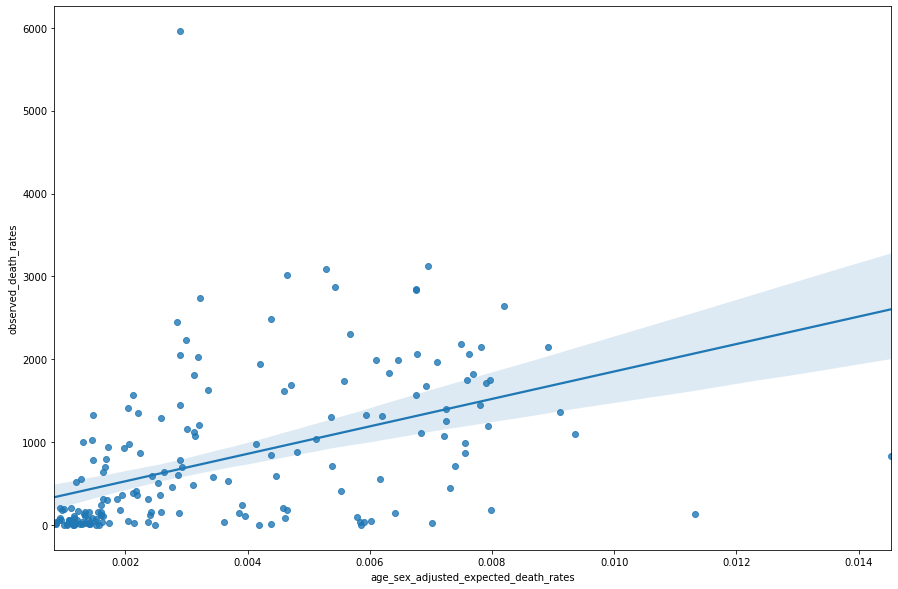

In [40]:
# Create scatterplot with regression line and confidence interval lines
plt.subplots(figsize=(15,10))
sns.regplot(x='age_sex_adjusted_expected_death_rates',
            y='observed_death_rates',
            data=df_merged,
            fit_reg=True)

In [41]:
# Define response variable
y = df_merged['observed_death_rates']

# Define explanatory variable
x = df_merged['age_sex_adjusted_expected_death_rates']

# Add constant to predictor variables
x = sm.add_constant(x)

# Fit linear regression model
model = sm.OLS(y, x).fit()

/Users/schinlfc/.pyenv/versions/3.8.10/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [42]:
# Create instance of influence
influence = model.get_influence()

# Obtain standardized residuals
standardized_residuals = influence.resid_studentized_internal

In [43]:
# Add standardized_residuals column to the DataFrame
df_merged['standardized_residuals'] = standardized_residuals
df_merged.sort_values(by=('standardized_residuals'))

,country,expected_deaths,pop,age_sex_adjusted_expected_death_rates,date,observed_death_rates,standardized_residuals
101,Japan,1.417690e+06,125135727,0.011329,2021-09-13,133.787,-2.466913
134,Monaco,4.514941e+02,31066,0.014533,2021-09-13,835.020,-2.312444
68,Finland,4.445457e+04,5572355,0.007978,2021-09-13,188.704,-1.661979
89,Hong Kong,5.081421e+04,7248206,0.007011,2021-09-13,28.201,-1.657169
145,New Zealand,2.881984e+04,4925334,0.005851,2021-09-13,5.555,-1.442510
...,...,...,...,...,...,...,...
42,Colombia,1.417747e+05,49828664,0.002845,2021-09-13,2451.671,2.207010
27,Brazil,6.822908e+05,212041332,0.003218,2021-09-13,2743.383,2.491598
25,Bosnia and Herzegovina,2.023573e+04,3832751,0.005280,2021-09-13,3084.151,2.493894
149,North Macedonia,9.875575e+03,2125463,0.004646,2021-09-13,3013.933,2.534921


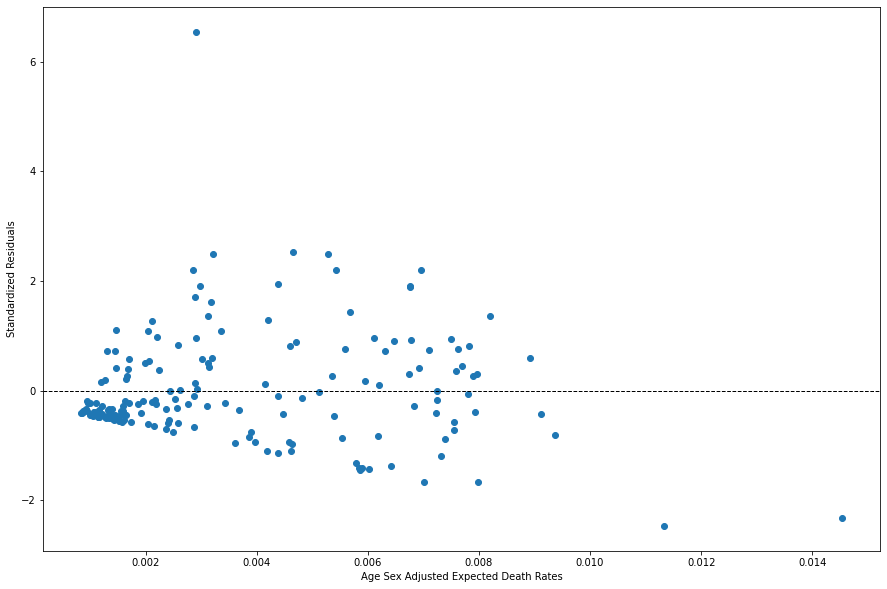

In [162]:
# Plot Standardized Residuals 
plt.subplots(figsize=(15,10))
plt.scatter(x='age_sex_adjusted_expected_death_rates', 
            y='standardized_residuals',
            data= df_merged)
plt.xlabel('Age Sex Adjusted Expected Death Rates')
plt.ylabel('Standardized Residuals')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)

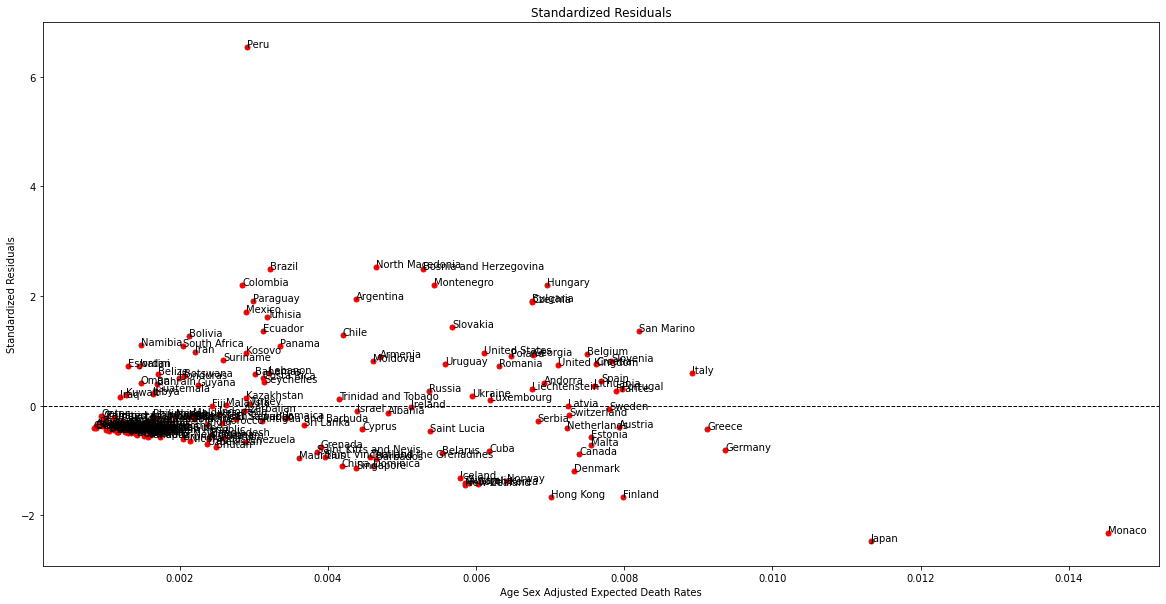

In [163]:
# Plot Standardized Residuals with country labels
plt.subplots(figsize=(20,10))

plt.scatter(x='age_sex_adjusted_expected_death_rates',
            y='standardized_residuals',
            data = df_merged,
            c="b",
            s=3**2,
            zorder=2)
plt.title('Standardized Residuals')
plt.xlabel('Age Sex Adjusted Expected Death Rates')
plt.ylabel('Standardized Residuals')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)

selectedCountries=list(df_merged['country'].unique())
mask=(df_merged['country'].isin(selectedCountries ))

plt.scatter(df_merged['age_sex_adjusted_expected_death_rates'][mask],
            df_merged['standardized_residuals'][mask],
            c="r",
            s=5**2,
            zorder=3)

for (x,y,label) in df_merged[['age_sex_adjusted_expected_death_rates',
                              'standardized_residuals','country']][mask].values:
    plt.text(x,y,label,zorder=4)